# **Дополнительное домашнее задание. Логистическая регрессия и решающие деревья**

Суммарно 10 баллов за всю работу. По 5 баллов в каждой части.

Требуется выполнить следующие задания.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random

from __future__ import annotations

## **Часть 1. Логистическая регрессия (5 баллов)**

**Задание 1 (3 балла)**. Реализуйте логистическую регрессию, обучаемую с помощью двух видов градиенткого спуска:
- полный (по всем данным) градиентный спуск;

- стохастический градиентный спуск;

Во всех пунктах необходимо соблюдать два условия:
- Циклы можно использовать только для итераций градиентного спуска.
- В качестве критерия останова необходимо использовать (одновременно):

    - проверку на евклидову норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка 1e-6), задаваемого параметром `tolerance`;
    - достижение максимального числа итераций (например, 10000), задаваемого параметром `max_iter`.

Чтобы проследить, что оптимизационный процесс действительно сходится, добавьте атрибут класса `loss_history`. В нем после вызова метода `fit` должны содержаться значения функции потерь для всех итераций градиентного спуска, начиная с нулевой.

Инициализировать веса можно случайным образом или нулевым вектором.

In [6]:
from sklearn.base import BaseEstimator

from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, auc

from sklearn.model_selection import KFold

In [7]:
class MyLogisticRegression(BaseEstimator):
    def __init__(self, gd_type: str = 'stochastic', tolerance: float = 1e-6,
                 max_iter: int = 1000, eta: float = 1e-2,
                 w0: np.array = None) -> None:
        """
        Аргументы:
          gd_type: вид градиентного спуска ('full' или 'stochastic').

          tolerance: порог для остановки градиетного спуска.

          max_iter: максимальное количество шагов в градиентном спуске.

          eta: скорость обучения (learning rate).

          w0: массив размерности d (d — количество весов в оптимизации).
              Начальные веса.
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.eta = eta
        self.w0 = w0
        self.w = None
        self.loss_history = None


    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))


    def fit(self, X: np.array, y: np.array) -> MyLogisticRegression:
        """Обучаем модель на training данных. Сохраняйте значении функции потерь после каждой итерации.

        Аргументы:
          X: данные на обучение.

          y: целевая переменная.

        Возвращает:
          self: обученный регрессор.
        """
        self.loss_history = []
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features) if self.w0 is None else self.w0

        
        for i in range(self.max_iter):
            prev_w = self.w.copy()
            
            if self.gd_type == 'full':
                grad = self.calc_gradient(X, y)
            elif self.gd_type == 'stochastic':
                idx = np.random.randint(n_samples)
                grad = self.calc_gradient(X[idx:idx+1], y[idx:idx+1])
            else:
                raise ValueError("Неверное значение gd_type. Оно должен быть 'full' или 'stochastic'")

            self.w -= self.eta * grad
            loss = self.calc_loss(X, y)
            self.loss_history.append(loss)

            if i > 0 and np.linalg.norm(self.w - prev_w) < self.tolerance:
                break

        return self


    def predict_proba(self, X: np.array) -> np.array:
        """Вычислите вероятности положительного и отрицательного классов для каждого наблюдения.

        Аргументы:
          X: массив размером (n, d).
             Данные.

        Возвращает:
             Массив размером (n, 2).
             Предсказанные вероятности.
        """
        if self.w is None:
            raise Exception('Not trained yet')

        pred = self.sigmoid(X @ self.w)
        return np.vstack([1 - pred, pred]).T


    def predict(self, X: np.array) -> np.array:
        """Предсказание метки класса для каждого наблюдения.

        Аргументы:
          X: массив размером (n, d).
             Данные.

        Возвращает:
             Массив размером (n,).
             Предсказанные метки классов.
        """
        if self.w is None:
            raise Exception('Not trained yet')
            
        #return np.argmax(self.predict_proba(X), axis = 1)

        return (self.predict_proba(X)[:, 1] > 0.5).astype(int)

    def calc_gradient(self, X: np.array, y: np.array) -> np.array:
        """Вычислите градиент функции потерь после каждой итерации.

        Аргументы:
          X: массив размером (n, d), n может быть равно 1, если выбран 'stochastic'.
          y: массив размером (n,).

        Возвращает:
          Массив размером (d,).
          Градиент функции потерь после текущей итерации.
        """
        y_pred = self.sigmoid(X @ self.w)
        return X.T @ (y_pred - y) / X.shape[0]


    def calc_loss(self, X: np.array, y: np.array) -> float:
        """Вычислите значение функции потерь после каждой итерации.

        Аргументы:
          X: массив размером (n, d).
          y: массив размером (n,).

        Возвращает:
          Значение функции потерь после текущей итерации.
        """
        y_pred = self.sigmoid(X @ self.w)
        loss = -np.mean(y * np.log(y_pred + 1e-9) + (1 - y) * np.log(1 - y_pred + 1e-9))
        return loss

Далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

Сгенерируем искусственные данные.

In [10]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=999)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=999)

**Задание 2 (1 балл).** Обучите логистическую регрессию на искусственных данных. Нарисуйте изменение лосса во время обучения.

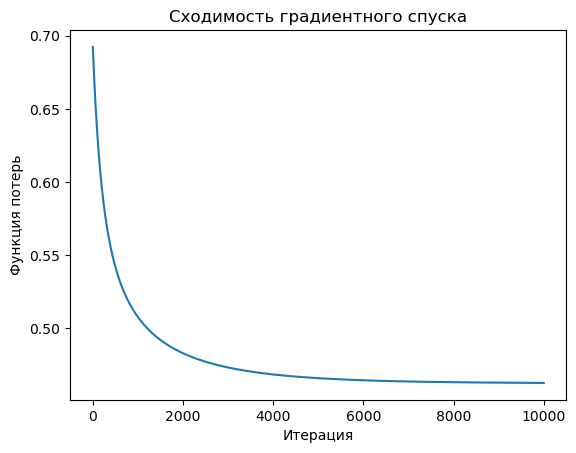

In [12]:
model = MyLogisticRegression(gd_type='full', max_iter=10000, eta=1e-3)
model.fit(X_train, y_train)

plt.plot(model.loss_history)
plt.xlabel("Итерация")
plt.ylabel("Функция потерь")
plt.title("Сходимость градиентного спуска")
plt.show()

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC- и PR-кривые.

In [14]:
y_scores = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_scores)
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
pr_auc = auc(recall, precision)

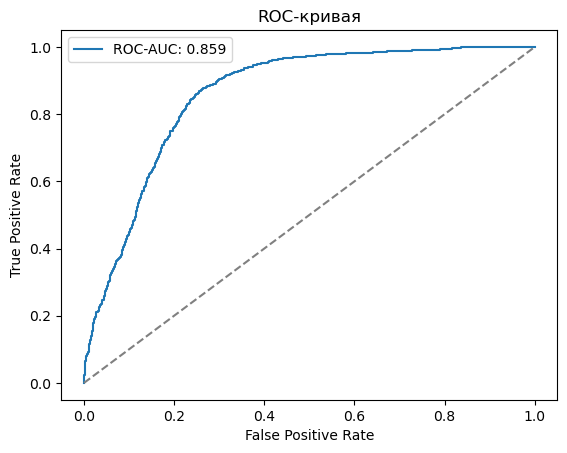

In [15]:
# ROC-кривая
fpr, tpr, _ = roc_curve(y_test, y_scores)
plt.plot(fpr, tpr, label=f"ROC-AUC: {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.legend()
plt.show()

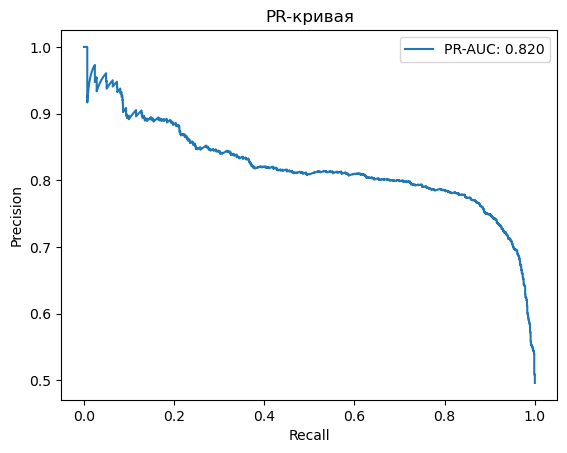

In [16]:
# PR-кривая
plt.plot(recall, precision, label=f"PR-AUC: {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR-кривая")
plt.legend()
plt.show()

**Задание 3 (1 балл).** Оцените ошибку ROC-AUC и PR-AUC вашей модели при помощи K-fold кросс-валидации.  

In [18]:
kf = KFold(n_splits=5, shuffle=True, random_state=999)
roc_auc_scores, pr_auc_scores = [], []

for train_index, val_index in kf.split(X):
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    model = MyLogisticRegression(gd_type='full', max_iter=1000, eta=1e-3)
    model.fit(X_train_fold, y_train_fold)

    y_val_scores = model.predict_proba(X_val_fold)[:, 1]
    roc_auc_scores.append(roc_auc_score(y_val_fold, y_val_scores))
    precision, recall, _ = precision_recall_curve(y_val_fold, y_val_scores)
    pr_auc_scores.append(auc(recall, precision))

print(f"Средний ROC-AUC: {np.mean(roc_auc_scores):.3f} ± {np.std(roc_auc_scores):.3f}")
print(f"Средний PR-AUC: {np.mean(pr_auc_scores):.3f} ± {np.std(pr_auc_scores):.3f}")    

Средний ROC-AUC: 0.846 ± 0.003
Средний PR-AUC: 0.810 ± 0.007


## **Часть 2. Решающие деревья (5 баллов)**

Здесь требуется реализовать разбиение элементов выборки в вершине дерева.

$R_m$ — множество объектов в разбиваемой вершине, $j$ — номер признака, по которому происходит разбиение, $t$ — порог разбиения.

Критерий ошибки:

$$
Q(R_m, j, t) = \frac{|R_\ell|}{|R_m|}H(R_\ell) + \frac{|R_r|}{|R_m|}H(R_r) \to \min_{j, t}
$$

$R_\ell$ — множество объектов в левом поддереве, $R_r$ — множество объектов в правом поддереве.

$H(R)$ — критерий информативности, с помощью которого можно оценить качество распределения целевой переменной среди объектов множества $R$.

In [22]:
from typing import Iterable, List, Tuple

Так как Boston Dataset с недавних пор отсутствует в sklearn, то ниже реализован способ загрузки данного датасета из другого источника.

In [24]:
# `load_boston` has been removed from scikit-learn since version 1.2.

#from sklearn.datasets import load_boston
#boston = load_boston()

In [25]:
# !wget -i https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/datasets/data/boston_house_prices.csv
data_git = pd.read_csv('boston_house_prices.csv', sep="\s+")

**Data Set Characteristics:**  

    :Number of Instances: 506

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's

    :Missing Attribute Values: None

    :Creator: Harrison, D. and Rubinfeld, D.L.

This is a copy of UCI ML housing dataset.
https://archive.ics.uci.edu/ml/machine-learning-databases/housing/

This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University.

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.

The Boston house-price data has been used in many machine learning papers that address regression
problems.   
     
.. topic:: References

   - Belsley, Kuh & Welsch, 'Regression diagnostics: Identifying Influential Data and Sources of Collinearity', Wiley, 1980. 244-261.
   - Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning. In Proceedings on the Tenth International Conference of Machine Learning, 236-243, University of Massachusetts, Amherst. Morgan Kaufmann.



In [27]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [28]:
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

X = pd.DataFrame(data, columns=feature_names, index=range(len(data)))
y = pd.DataFrame(target, columns=['MEDV'], index=range(len(target)))

X['target'] = y

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.25, random_state=999)

**Задание 1 (1 балл)**. Реализуйте подсчет критерия ошибки. Для этого реализуйте функции для подсчета значения критерия информативности, а также для разбиения вершины.

In [31]:
def H(R: np.array) -> float:
    """
    Вычислить критерий информативности (impurity criterion) для фиксированного набора объектов R.
    Предполагается, что последний столбец содержить целевую переменную.
    """
    y = R.iloc[:, -1]
    return y.var()


def split_node(R_m: np.array, feature: str, t: float) -> Iterable[np.array]:
    """
    Разделить фиксированный набор объектов R_m с заданным признаком (номером признака) и пороговым значением t.
    """
    # left_mask = R_m.loc[:, feature] <= t
    # right_mask = R_m.loc[:, feature] > t

    left_mask = R_m[feature] <= t
    right_mask = R_m[feature] > t
    
    return R_m[left_mask], R_m[right_mask]


def q_error(R_m: np.array, feature: str, t: float) -> float:
    """
    Вычислить критерий ошибки для заданных параметров разделения.
    """
    R_left, R_right = split_node(R_m, feature, t)

    if len(R_left) == 0 or len(R_right) == 0:
        return np.inf
    
    n_left, n_right = len(R_left), len(R_right)
    n_total = len(R_m)
    
    return (n_left / n_total) * H(R_left) + (n_right / n_total) * H(R_right)

**Задание 2 (1 балл)**. Переберите все возможные разбиения обучающей выборки по одному из признаков и постройте график критерия ошибки в зависимости от значения порога.

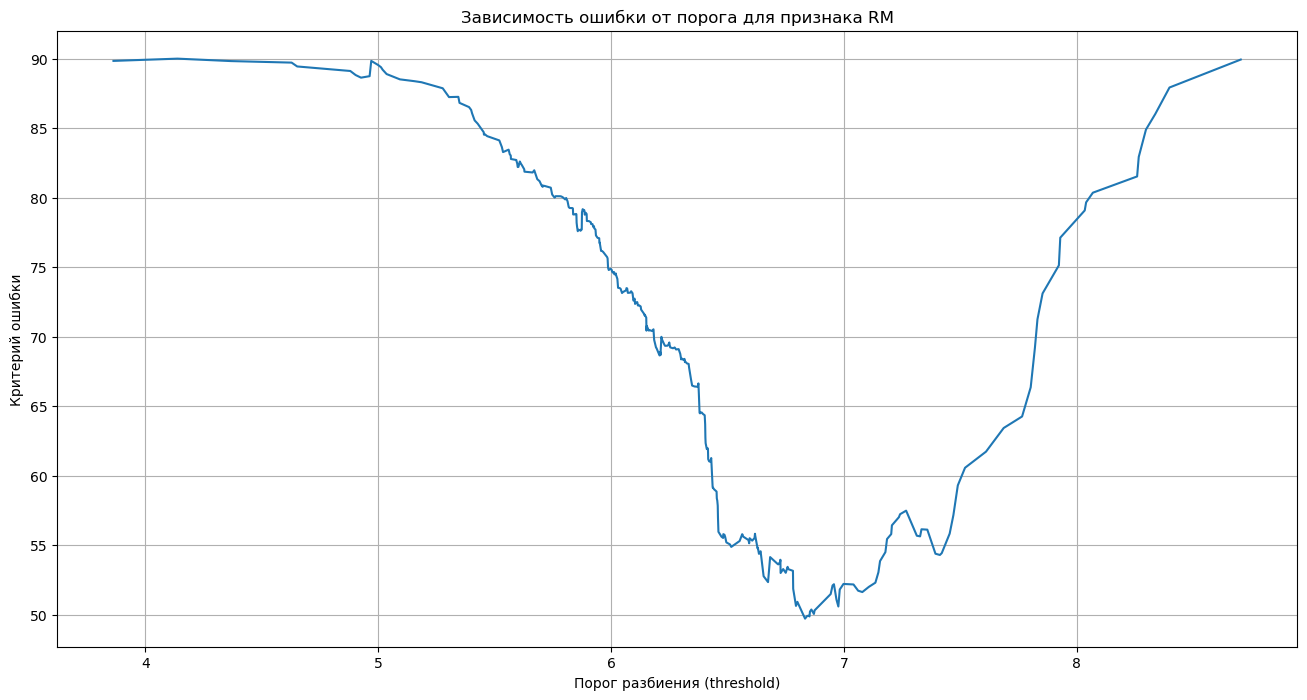

In [33]:
# your code

feature_idx = 5
R_m = X_train
feature_name = feature_names[feature_idx]
thresholds = np.sort(R_m[feature_name].unique())

errors = [q_error(X_train, feature_name, t) for t in thresholds]

plt.figure(figsize = (16,8))
plt.plot(thresholds, errors)
plt.xlabel('Порог разбиения (threshold)')
plt.ylabel('Критерий ошибки')
plt.title(f'Зависимость ошибки от порога для признака {feature_name}')
plt.grid()
plt.show()

**Задание 3  (1 балл)**. Напишите функцию, находящую оптимальное разбиение данной вершины по данному признаку.

In [35]:
def get_optimal_split(R_m: np.array, feature: str) -> Tuple[float, List[float]]:       
    thresholds = np.sort(R_m[feature].unique())
    min_error = np.inf
    best_treshold = thresholds[0] if len(thresholds) > 0 else 0
    errors = []
    
    for t in thresholds:
        current_error = q_error(R_m, feature, t)
        errors.append(current_error)
        if current_error < min_error:
            min_error = current_error
            best_treshold = t
    
    return best_treshold, errors

**Задание 4  (1 балл)**. Для первого разбиения найдите признак, показывающий наилучшее качество. Каков порог разбиения и значение качества? Постройте график критерия ошибки для данного признака в зависимости от значения порога.

In [37]:
best_feature = None
best_threshold = None
min_error = np.inf

for feature in feature_names:
    threshold, errors = get_optimal_split(X_train, feature)
    current_error = min(errors)
    
    if current_error < min_error:
        min_error = current_error
        best_feature = feature
        best_threshold = threshold

print(f"Лучший признак: {best_feature}")
print(f"Оптимальный порог: {best_threshold}")
print(f"Минимальное значение критерия ошибки: {min_error}")

Лучший признак: TAX
Оптимальный порог: 403.0
Минимальное значение критерия ошибки: 71.8048541902366


 **Задание 5 (1 балл)**. Изобразите разбиение визуально. Для этого постройте диаграмму рассеяния целевой переменной в зависимости от значения входного признака. Далее изобразите вертикальную линию, соответствующую порогу разбиения.

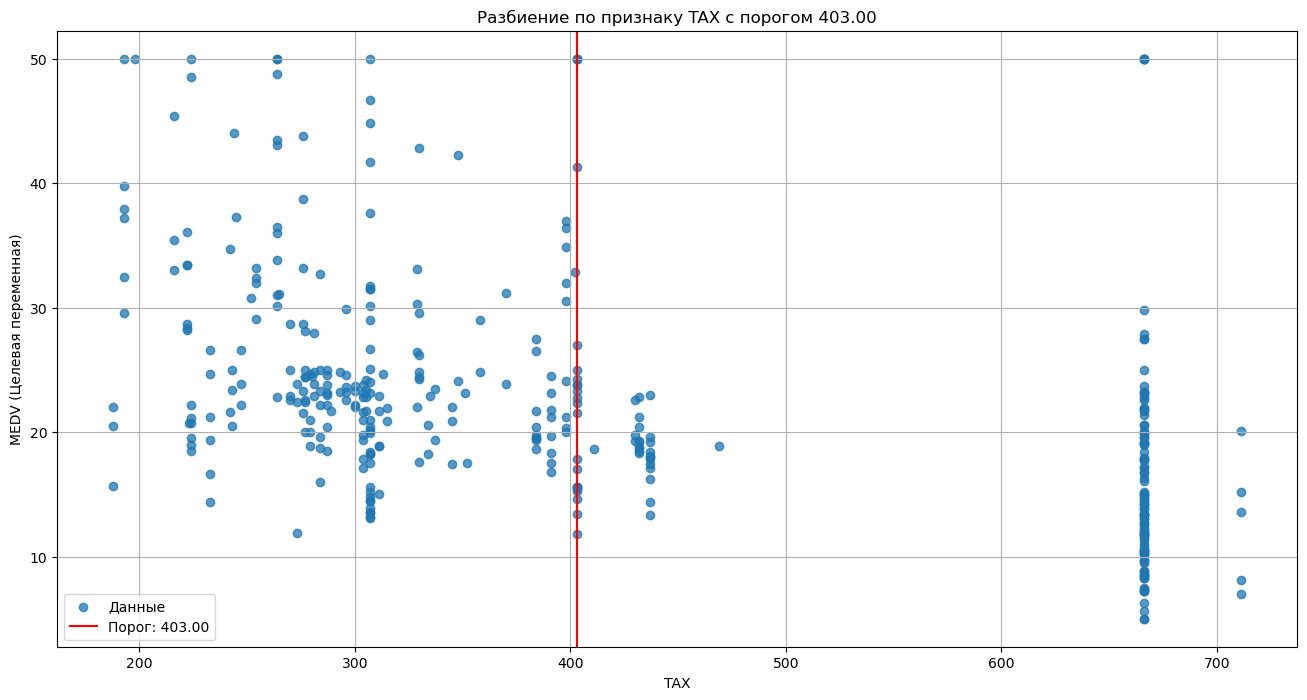

In [39]:
plt.figure(figsize = (16,8))

plt.scatter(
    X_train[best_feature],
    X_train['target'],
    alpha = 0.75,
    label='Данные',
)

plt.axvline(
    x = best_threshold,
    color = 'red',
    label=f'Порог: {best_threshold:.2f}'
)

plt.xlabel(best_feature)
plt.ylabel('MEDV (Целевая переменная)')
plt.title(f'Разбиение по признаку {best_feature} с порогом {best_threshold:.2f}')
plt.legend()
plt.grid(True)
plt.show()